In [22]:
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [23]:
class function:
    def __init__(self, dim, value, grad, hessian):
        self.dim = dim
        self.value = value
        self.grad = grad
        self.hessian = hessian

In [24]:
class probleme:
    def __init__(self, f):
        self.f = f
        
    def __call__(self, x):
        return self.f.value(x)

In [36]:
f_d = {
    "dim": 1,
    "value": lambda x: x[0]**2 - 5 * x[0] + 3,
    "grad": lambda x: np.array([2*x[0] - 5]),
    "hessian": lambda x: np.diag([2])
}
f_1 = function(**f_d)
P = probleme(f)

# Méthode de Newton

In [26]:
def backtracking(f, x, alpha=0.1, beta=0.8):
    pass

In [27]:
class Newton:
    def __init__(self, f, epsilon=0.01):
        self.epsilon = epsilon
        self.f = f
        self.save = np.array([])
        
    def __call__(self, x0):
        self.save = []
        x = x0
        self.save.append(x)
        dxN = -1 * np.dot(np.linalg.inv(self.f.hessian(x)), self.f.grad(x))
        lmd = -1 * np.dot(self.f.grad(x).T, dxN)
        while lmd / 2 > self.epsilon:
            dxN = -1 * np.dot(np.linalg.inv(self.f.hessian(x)), self.f.grad(x))
            lmd = -1 * np.dot(self.f.grad(x).T, dxN)
            t = 0.5
            x = x + t * dxN
            self.save.append(x)
        self.save = np.array(self.save)
        return x
    
    def plot(self):
        if self.save.shape[0] == 0:
            raise Exception("The Newton method algorithm has not been run")
        if self.f.dim == 1:
            plt.figure(figsize=(15, 15))
            x = np.linspace(-6, 6, 1000).reshape((1, -1))
            plt.plot(x.reshape((-1)), self.f.value(x))
            plt.plot(self.save[:, 0], np.zeros((self.save.shape[0])), "rx")
            plt.show()
        elif self.f.dim == 2:
            plt.figure(figsize=(15, 15))
            x, y = np.linspace(-2, 2, 200), np.linspace(-2, 2, 200)
            X, Y = np.meshgrid(x, y)
            x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(2, -1)
            plt.contour(X, Y, self.f.value(x_y).reshape(200, -1), 15)
            plt.plot(self.save[:, 0], self.save[:, 1], "rx")
            plt.grid()
            plt.show()
        else:
            raise Exception("Dimension > 2 not implemented")

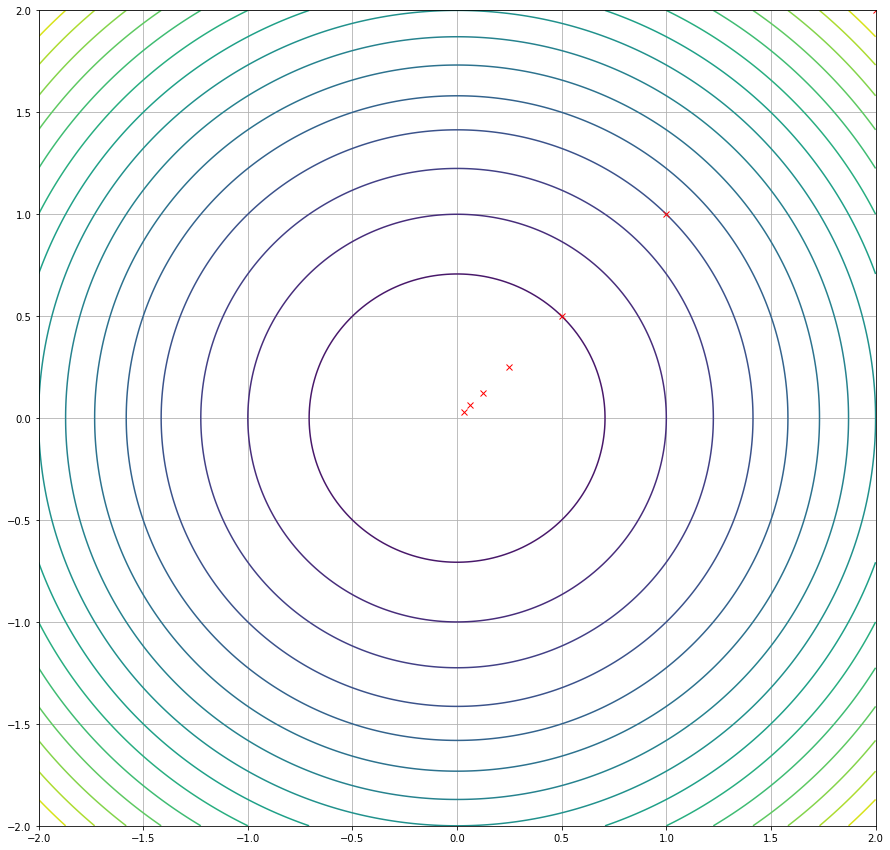

In [28]:
meth = Newton(f_2)
meth(np.array([2, 2]))
meth.plot()

# Descente de Gradient

In [46]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a GD object.
    
        Attributes:
        ddir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - x (ndarray): current iterate
              - f (function): objective function
              - dir_x (ndarray) : descent direction
              - grad (function) : gradient function
              - nb_iter (int): number of iterations.
              - eta (float): hyper-parameter.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
    
    def __call__(self, x, f, grad, verbose=False):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
            grad: function outputing gradient value of function f at a given point.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            (ndarray) list of graidents of iterates.
            (int) number of iterations.
            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            delta_x =  rate_ * dir_x
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter)

In [47]:
GD_default = GD()

In [114]:
op_pt, iters, iters_dir, n_iter = GD_default(np.array([10]), (lambda x : f_1.value ([x])),
                                             (lambda x, f, tol : f_1.grad(x)), True)

 Iteration nu. = 818
 approx. = [2.5000005]
 ob value = [[-3.25]]
 and decay = 9.977487120949036e-07.


In [150]:
newt = Newton(f_1)
newt(np.array([10]))

array([2.52929688])

In [159]:
iters_dir

array([[-1.50000000e-01],
       [-1.50000000e-01],
       [-1.47000000e-01],
       [-1.44060000e-01],
       [-1.41178800e-01],
       [-1.38355224e-01],
       [-1.35588120e-01],
       [-1.32876357e-01],
       [-1.30218830e-01],
       [-1.27614453e-01],
       [-1.25062164e-01],
       [-1.22560921e-01],
       [-1.20109703e-01],
       [-1.17707509e-01],
       [-1.15353358e-01],
       [-1.13046291e-01],
       [-1.10785365e-01],
       [-1.08569658e-01],
       [-1.06398265e-01],
       [-1.04270300e-01],
       [-1.02184894e-01],
       [-1.00141196e-01],
       [-9.81383718e-02],
       [-9.61756044e-02],
       [-9.42520923e-02],
       [-9.23670505e-02],
       [-9.05197095e-02],
       [-8.87093153e-02],
       [-8.69351290e-02],
       [-8.51964264e-02],
       [-8.34924979e-02],
       [-8.18226479e-02],
       [-8.01861949e-02],
       [-7.85824711e-02],
       [-7.70108216e-02],
       [-7.54706052e-02],
       [-7.39611931e-02],
       [-7.24819692e-02],
       [-7.1

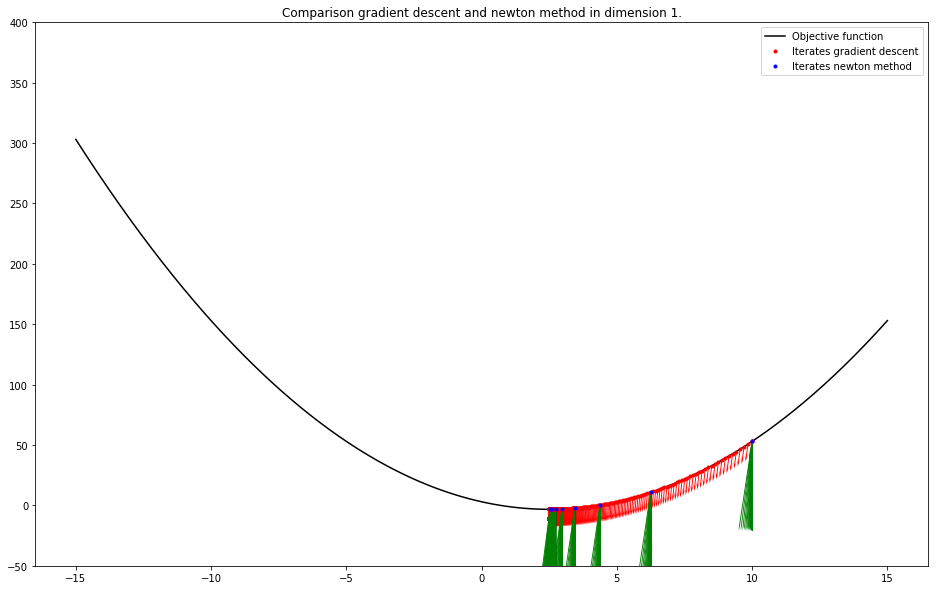

In [158]:
fig, ax = plt.subplots(figsize=(16, 10))
f = lambda x: f_1.value(x.reshape(1, -1))
x = np.linspace(-15, 15, 600)
ax.set_ylim(-50, 400)
ax.plot(x, f(x), "k-", label="Objective function")
# reshaping iters for input
iters_reshape = iters.reshape(iters.shape[0], 1)
ax.plot(iters_reshape, f(iters_reshape), 'r.', label="Iterates gradient descent")
ax.quiver(iters_reshape, f(iters_reshape), iters_dir, -1, 
          color='r', scale=None, width=0.001, headwidth=4, headlength=10)

ax.plot(newt.save, f(newt.save), 'b.', label="Iterates newton method")
ax.quiver(newt.save, f(newt.save), iters_dir, -1, 
          color='g', scale=10, width=0.001, headwidth=2, headlength=10)

ax.set_title("Comparison gradient descent and newton method in dimension 1.")
ax.legend()
print()